In [9]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
import pandas as pd
from torch.utils.data import TensorDataset,DataLoader
import joblib
import requests
from tqdm import tqdm_notebook as tqdm
from pytorch_lightning import seed_everything
import random
import warnings 
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
exec(requests.get('https://raw.githubusercontent.com/facebookresearch/madgrad/main/madgrad/madgrad.py').text)

In [10]:
# Load data
data = joblib.load('..\data\dataset.pkl')

data['value'] = data['value'][:,[0]]
data['value_col'] = data['value_col'][:1]

batch_size = 1
hidden_size = 128
state_size = data['state'].shape[-1]
request_size = data['value'].shape[-1]
value_size = data['value'].shape[-1]
action_size = data['action'].shape[-1]
time_step = 144


In [11]:

class R2D2(nn.Module):
  def __init__(self,obs_size,n_actions,hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.l1 = nn.Linear(obs_size,self.hidden_size)
    self.l2 = nn.LSTMCell(self.hidden_size,self.hidden_size)
    self.l3 = nn.Linear(self.hidden_size,n_actions)
  
  def forward(self,x,hx,cx):
    x = torch.tanh(self.l1(x))
    hx,cx = self.l2(x,(hx,cx))
    x = torch.tanh(hx)
    x = torch.sigmoid(self.l3(x)) # to range[0,1]
    return x,hx,cx


In [12]:
class ActorCritic(nn.Module):
  def __init__(self,actor,critic,time_step):
    super().__init__()
    self.time_step = time_step
    
    self.actor = actor
    self.actor_optimizer = MADGRAD(actor.parameters() ,lr = 1e-3)
    
    self.critic = critic
    self.critic_optimizer = MADGRAD(critic.parameters() ,lr = 1e-3)
  
  def forward(self,state,request):
    actions = self.actor_forward(state,request)
    values = self.critic_forward(state,actions)
    return values

  def actor_forward(self,state,request,eval=False):
    '''
    # 給定狀態(不可控)和需求 輸出一系列動作
    '''
    # train or eval model
    if eval == True:
      self.actor.eval()
    else:
      self.actor.train()
    
    # initialize hx,cx
    hx = torch.zeros((state.size()[0],actor.hidden_size))
    cx = torch.zeros((state.size()[0],actor.hidden_size))
    
    # get actions shape(batch_size,time_step,action_size)
    actions = torch.FloatTensor()
    
    # 對一定時間長度進行遍歷
    for t in range(self.time_step):
      # 在t時刻 根據t時刻的狀態,需求以及短期記憶hx,長期記憶cx當作輸入,得到輸出a(動作),更新後的短期記憶hx,更新後的長期記憶cx
      a,hx,cx = self.actor(torch.cat((state[:,t,:],request),dim=1),hx,cx)
      actions = torch.cat((actions,a),dim=1)
    # 一系列動作 (Batch,Time,Features)
    actions = actions.reshape(state.size()[0],self.time_step,-1)
    
    return actions
  
  def critic_forward(self,state,action,eval=False):
    '''
    # 輸入狀態(不可控)和一系列動作(可控),預測產出
    '''

    # train or eval model
    if eval == True:
      self.critic.eval()
    else:
      self.critic.train()
    
    # initialize hx,cx
    hx = torch.zeros((state.size()[0],critic.hidden_size))
    cx = torch.zeros((state.size()[0],critic.hidden_size))

    # get values shape(batch_size,time_step,value_size)
    values = torch.FloatTensor()
    
    # 對時間點遍歷
    for t in range(self.time_step):
      # 根據當前t時刻狀態,動作,hx,cx當輸入得到,v(產出),更新hx,cx
      v,hx,cx = self.critic(torch.cat((state[:,t,:],action[:,t,:]),dim=1),hx,cx)
      values = torch.cat((values,v),dim=1)
    
    # 一系列產出(Batch,Time,Features)
    values = values.reshape(state.size()[0],self.time_step,-1)
    
    # 只取最後一個時間點
    return values[:,-1,:] # return last time_step

  def train_critic(self,state,action,value):
    '''
    x: [state,action]
    y: [value]
    '監督式學習'
    '''
    self.critic.train()
    self.actor.eval()
    value_hat = self.critic_forward(state,action)
    
    # 預測值跟label的平方差愈小愈好
    loss = ((value_hat-value)**2).mean()
    loss.backward()
    self.critic_optimizer.step()
    self.critic_optimizer.zero_grad()
    return loss.item()
  
  def train_actor(self,state,request):
    '''
    x: [state,request]
    y: maximum critic value
    '最小化產出跟request的差異'
    '''
    self.actor.train()
    self.critic.eval()
    actions = self.actor_forward(state,request)
    value_hat = self.critic_forward(state,actions)

    # 首先預測值跟需求的平方差愈小愈好
    loss1 = ((request-value_hat)**2).mean()

    # 再來避免"變異數太大(時間維度上)" 因為盤控人員不可能突然調太多
    loss2 = actions.reshape(-1,time_step,action_size).std(axis=1)
    loss2 = loss2.sum(axis=-1).mean(axis=0)

    loss = loss1 + loss2
    loss.backward()
    
    self.actor_optimizer.step()
    self.actor.zero_grad()

    return loss.item()

In [13]:
actor = R2D2(state_size+request_size,action_size,hidden_size)
actor.load_state_dict(torch.load('../model/actor.pth'))
critic = R2D2(state_size+action_size,value_size,hidden_size)
critic.load_state_dict(torch.load('../model/critic.pth'))
model = ActorCritic(actor,critic,time_step)

,H-110 裂解度
count,1064.000000
mean,0.000183
std,0.000031
min,0.000000
25%,0.000180
50%,0.000188
75%,0.000195
max,0.000246


,0
count,1064.000000
mean,0.000217
std,0.000017
min,0.000188
25%,0.000203
50%,0.000216
75%,0.000231
max,0.000246


,H-110 裂解度
count,1064.000000
mean,0.000183
std,0.000031
min,0.000000
25%,0.000180
50%,0.000188
75%,0.000195
max,0.000246


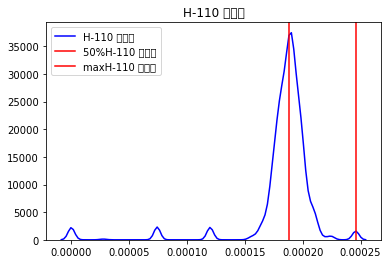

(1064, 144, 8)
(1064, 144, 9)
(1064, 1)
(1064, 1)


In [14]:
a = pd.DataFrame(data['value'],columns=data['value_col']).describe()
display(a)

data['request'] = None
for i in data['value_col']:
    if data['request'] is None:
        data['request'] = np.random.uniform(low=a.loc['50%',i],high=a.loc['max',i],size=(data['value'].shape[0],1))
    else:
        var = np.random.uniform(low=a.loc['50%',i],high=a.loc['max',i],size=(data['value'].shape[0],1))
        data['request'] = np.hstack([data['request'],var])
b = pd.DataFrame(data['request']).describe()
display(b)

a = pd.DataFrame(data['value'],columns=data['value_col'])
display(a.describe())
for i in data['value_col']:
    sns.kdeplot(a[i],color='b')
    plt.axvline(x=a.describe().loc['50%',i], label= "50%"+i, c='r')
    plt.axvline(x=a.describe().loc['max',i], label= "max"+i, c='r')
    plt.legend()
    plt.title(i)
    plt.show()
describe = a.describe()



# shape
print(data['state'].shape)
print(data['action'].shape)
print(data['value'].shape)
print(data['request'].shape)

# tensor
data['state'] = torch.FloatTensor(data['state'])
data['request'] = torch.FloatTensor(data['request'])
data['action'] = torch.FloatTensor(data['action'])
data['value'] = torch.FloatTensor(data['value'])



# data_iter
data = TensorDataset(data['state'],data['request'],data['action'],data['value'])
train_iter = DataLoader(data,batch_size=batch_size,shuffle=True)

In [21]:
wanna_ouput = [0.0001947947148678194]
real_value = []
pred_value = []
for i in tqdm(range(365)):
    s,r,a,v = next(iter(train_iter))
    s = s[0].reshape(-1,time_step,state_size)
    r = torch.full((1,1),wanna_ouput[0])
    a_ = model.actor_forward(s,r,eval=True) # 模型建議操作
    v_ = model.critic_forward(s,a,eval=True) # 模型預測輸出
    pred_value.append(v_.detach().numpy()[0])
    real_value.append(v.detach().numpy()[0])
pred_value = np.array(pred_value)
real_value = np.array(real_value)

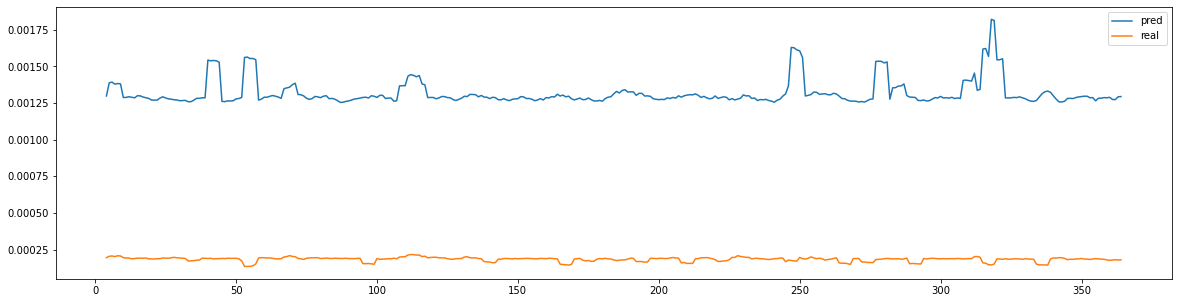

In [22]:
plt.figure(figsize=(20,5))
plt.plot(pd.Series(pred_value[:,0]).rolling(5).mean(),label='pred')
plt.plot(pd.Series(real_value[:,0]).rolling(5).mean(),label='real')
plt.legend()
plt.show()

In [23]:
import numpy as np

def mape(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

print('mape',mape(real_value[:,0],pred_value[:,0]))

mape 20.05952
